In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# https://chat.openai.com/c/678af586-b65f-4e12-8279-a8d629aa2284  refer it for the clarificaiton of the df.loc and some initial working of code

In [2]:
plt.rcParams["figure.figsize"] = (9,6)

In [3]:
# Reading the Dataset
df=pd.read_csv('ec2_cpu_utilization_24ae8d.csv')
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [4]:
#  time where the anomalies have occured
anomalies_timestamp = [
        "2014-02-26 22:05:00",
        "2014-02-27 17:15:00",
    	
    ]

In [5]:
# putting 1 for anomaly for all 
df['is_anomaly'] = 1
# putting anomaly fro the point where time stamp mathces given in the anomalies_timestamp
for each in anomalies_timestamp:
    df.loc[df['timestamp'] == each, 'is_anomaly'] = -1
    
df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [6]:
anomaly_df=df.loc[df['is_anomaly']== -1   #  row where their is anomaly
inlier_df=df.loc[df['is_anomaly']==1]     # rows which are normal
print(anomaly_df)   

                timestamp  value  is_anomaly
3547  2014-02-26 22:05:00  2.344          -1
3777  2014-02-27 17:15:00  0.602          -1


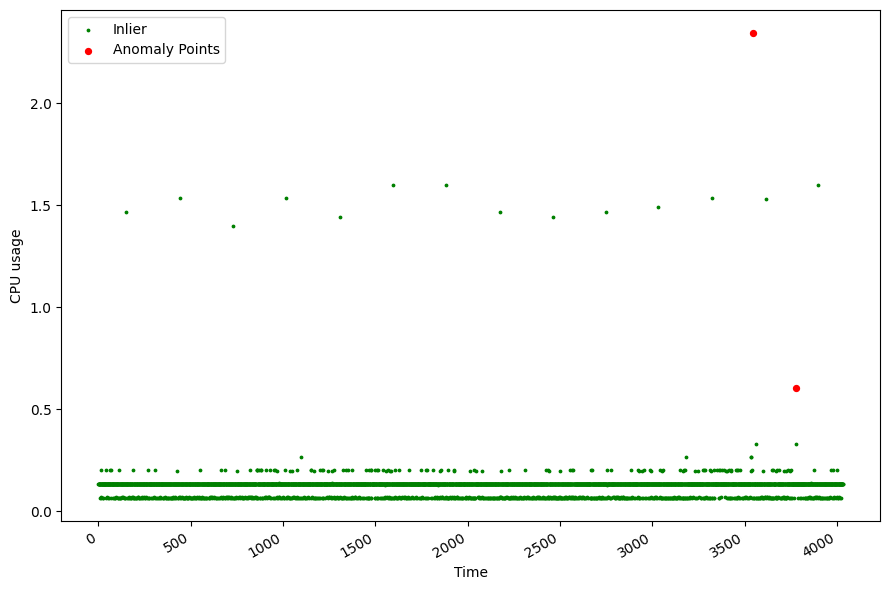

In [11]:
fig,ax=plt.subplots()
# This line creates a scatter plot on the axes ax. It plots the data points from the DataFrame inlier_df, where inlier_df.index represents
# the x-values (assumed to be timestamps or indices) and inlier_df['value'] represents the y-values. The points are colored green, have a size of 3,
# and are labeled as "Inlier" in the legend.
ax.scatter(inlier_df.index, inlier_df['value'],color="green",s=3,label="Inlier")
ax.scatter(anomaly_df.index,anomaly_df['value'],color='red',s=18,label="Anomaly Points")
ax.set_xlabel('Time')
ax.set_ylabel('CPU usage')
ax.legend(loc=2)

plt.grid(False)
fig.autofmt_xdate()
plt.tight_layout()

****Baseline: median absolute deviation (MAD)****


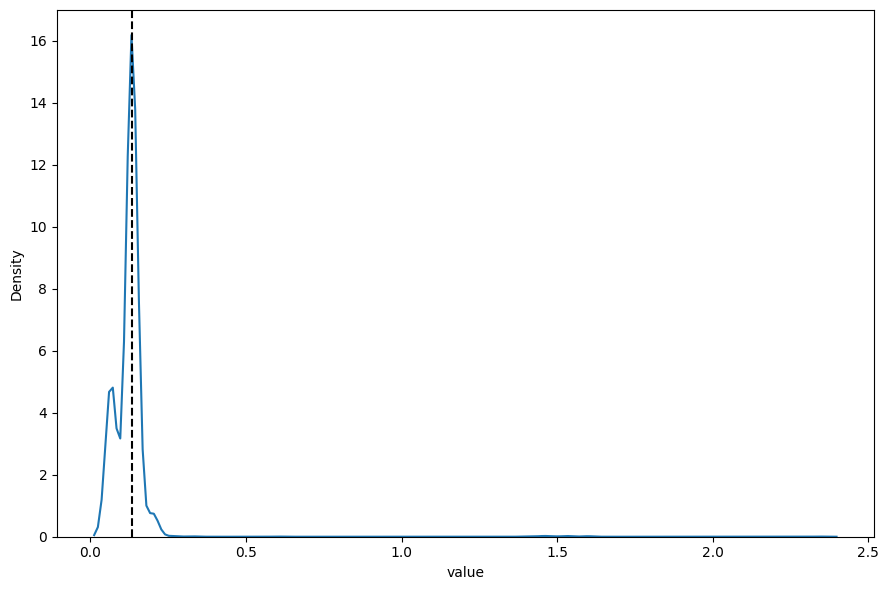

In [13]:
import seaborn as sns

sns.kdeplot(df['value'])
plt.grid(False)
plt.axvline(0.134, 0, 1, c='black', ls='--')
plt.tight_layout()

In [14]:
from scipy.stats import median_abs_deviation
mad= median_abs_deviation(df['value'])
median= np.median(df['value'])
print(median)
print(mad)
def compute_robust_z_score(x):
    return .6745*(x-median)/mad

0.134
0.0020000000000000018


In [15]:
# adding column for the z swcore for corresponding vlaues
df['z-score']=df['value'].apply(compute_robust_z_score)
df.head()

,timestamp,value,is_anomaly,z-score
0,2014-02-14 14:30:00,0.132,1,-0.6745
1,2014-02-14 14:35:00,0.134,1,0.0000
2,2014-02-14 14:40:00,0.134,1,0.0000
3,2014-02-14 14:45:00,0.134,1,0.0000
4,2014-02-14 14:50:00,0.134,1,0.0000


In [16]:
df['baseline']=1
# we are consifering 3.5 are threshold for this
df.loc[df['z-score']>=3.5,'baseline']=-1 # putting baseline as -1 where z- score >=3.5 
df.loc[df['z-score']<=-3.5,'baseline']= -1

**Evaluation**

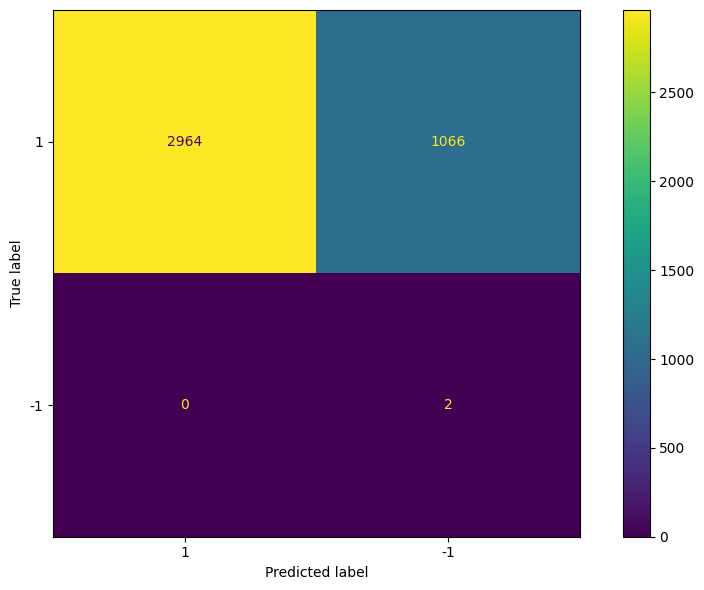

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm= confusion_matrix(df['is_anomaly'], df['baseline'], labels=[1,-1])
disp_cm=ConfusionMatrixDisplay(cm,display_labels=[1,-1])
disp_cm.plot()
plt.grid(False)
plt.tight_layout()

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(df['is_anomaly'],df['baseline'])

0.7356150793650794

**Isolation Forest**

In [20]:
from sklearn.ensemble import IsolationForest

In [24]:
# making set for train and test
train=df[:3550]   # means first 3550 rows
test=df[3550:]    # means next all entries from 3550th row

In [23]:
# just for understanding
arr=np.array([1,2,3,4,5])
print(arr[:3])
print(arr[4:])

[1 2 3]
[5]


In [25]:
contamination=1/len(train)  #, if contamination is set to 0.1, it means that it expects 10% of the data points to be outliers.
#Setting contamination is important because it helps the isolation forest algorithm to determine the threshold for classifying points as outliers.
# random_state=42 random_state make things fix for that state now we know a diffrent tree can generate hence we are makingn random_state equal to something this could be any number data scienctis
# generally use 42 , this make a state where you run the algorithm for many time u get same result
# remember randomization doesn't have any realtion with what the number is it just focus of does it change or not
iso_forest= IsolationForest(contamination=contamination,random_state=42)
X_train=train['value'].values.reshape(-1,1)
iso_forest.fit(X_train)

IsolationForest(contamination=0.00028169014084507044, random_state=42)

Link to understand random_state

https://www.youtube.com/watch?v=Y1E09DPaCrs

In [27]:
x_test= test['value'].values.reshape(-1,1)
predict_iso_forest=iso_forest.predict(x_test)

**Evaluation of Isolation Tree**

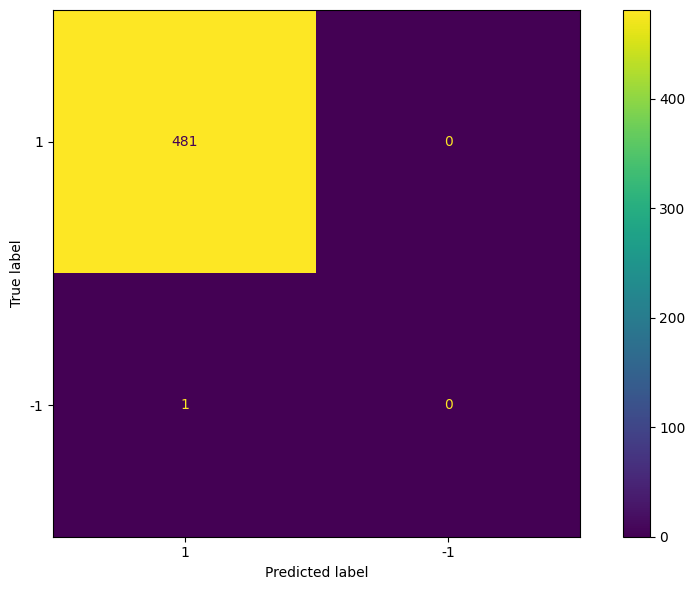

In [31]:
cm2=confusion_matrix(test['is_anomaly'],predict_iso_forest,labels=[1,-1])
disp_cm2=ConfusionMatrixDisplay(cm2,display_labels=[1,-1])

disp_cm2.plot()
plt.grid(False)
plt.tight_layout()

In [33]:
accuracy_score(test['is_anomaly'],predict_iso_forest)

0.9979253112033195

Accuracy of IsolationTree: **99.79253112033195%**


**Local Outlier Factor**



In [35]:
from sklearn.neighbors import LocalOutlierFactor
lof=LocalOutlierFactor(contamination=contamination, novelty=True)
lof.fit(X_train)

LocalOutlierFactor(contamination=0.00028169014084507044, novelty=True)

In [36]:
predict_lof=lof.predict(x_test)

**Evaluation of LOF**

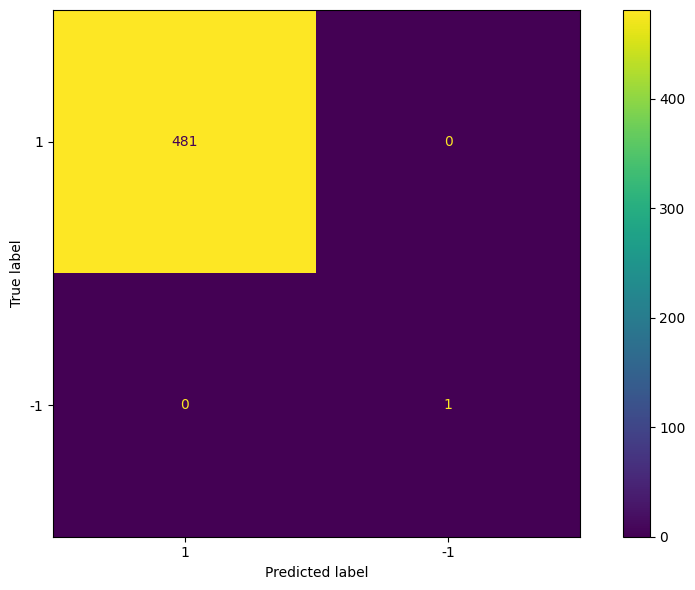

In [41]:
cm3=confusion_matrix(test['is_anomaly'],predict_lof,labels=[1,-1])
disp_cm3=ConfusionMatrixDisplay(cm3,display_labels=[1,-1])

disp_cm3.plot()
plt.grid(False)
plt.tight_layout()

In [42]:
accuracy_score(test['is_anomaly'],predict_lof)

1.0

Accuracy Score of LOF: **100%**

**THANK YOU**

Some website you can refer for better understanding

https://medium.com/@corymaklin/isolation-forest-799fceacdda4